In [165]:
import numpy as np
import myfun as mf
import copy

import matplotlib

from matplotlib import colors, ticker, gridspec, rc, transforms
from matplotlib.ticker import PercentFormatter, LogFormatter, FuncFormatter, LogLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt

from sklearn import naive_bayes as NB
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from numpy import linalg as linalg
from importlib import reload

from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import minimize, basinhopping, dual_annealing

import emcee

In [6]:
deck=np.hstack([[i for j in range(4) for i in range(1,10)],10*np.ones(16)])

In [16]:
ncards = len(deck)
ngames = 100


In [18]:
np.array_equal(np.sort(deck[shuf]),np.sort(deck))

True

In [242]:
z=[]
idxs2pop[z[0]]

IndexError: list index out of range

In [342]:
idxs2pop         = [[-3,-2,-1], [-2,-1,0], [-1,0,0]]

def play_game(seed=None, npiles_init = 7, max_iter = 1000):
    
    np.random.seed(seed)

    won        = False
    piles      = [[] for i in range(npiles_init)]
    
    shuf       = np.random.choice(np.arange(ncards),size=ncards,replace=False)
    game_deck  = list(np.array(deck[shuf],dtype=int))
    pos        = 0
    remove_idx = -1
    iter_ct    = 0 
    while len(game_deck)>0 and not won and iter_ct < max_iter:
        iter_ct += 1
        for i in range(pos,len(piles)):

            piles[i].append(game_deck.pop(0))

            #set_idxs = get_set(piles[i])
            set_pick = get_set_strat(piles[i])
            set_idxs = idxs2pop[set_pick[0]] if len(set_pick) > 0 else None
            while set_idxs:
                for idx in set_idxs:
                    game_deck.append(piles[i].pop(idx))
                set_idxs = get_set(piles[i])

            if len(piles[i]) == 0:
                remove_idx = i
                break

            if len(game_deck) == 0: # lost
                break

        if remove_idx > -1:
            piles.pop(remove_idx)
            if len(piles) == 1: # won
                won = True
            pos = copy.copy(remove_idx)
            remove_idx = -1
        else:
            pos = 0
    
    return piles, game_deck, iter_ct

In [343]:
ngames = 1000
ps     = [play_game() for i in range(ngames)]

In [344]:
npiles = [len(gm[0]) for gm in ps]

In [345]:
bins = np.arange(1,9)
bcs = np.histogram(npiles,bins,density=True)[0]
bin_ctrs = 0.5*(bins[1:]+bins[:-1])

In [346]:
bcs

array([0.022, 0.026, 0.06 , 0.157, 0.238, 0.318, 0.179])

(0.5, 7.5)

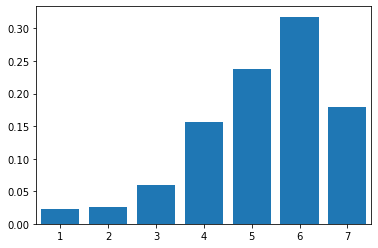

In [347]:
fig,axs=plt.subplots()
axs.bar(bins[:-1],bcs)
axs.set_xlim(0.5,7.5)

In [157]:
p,d,ic = play_game(seed=1)

In [86]:
np.array_equal(np.sort(mf.flatten2d(piles)),np.sort(deck))

True

In [72]:
piles

[[10.0, 9.0, 7.0],
 [3.0],
 [10.0, 8.0],
 [7.0, 10.0],
 [5.0, 4.0],
 [9.0, 6.0],
 [1.0, 10.0]]

In [200]:
win_sums = [10,20,30]
def get_set(pile):
    if len(pile) < 3:
        return None
    elif len(pile) == 3:
        if sum(pile)%10==0:
            return [-3,-2,-1]
        else: 
            return None
    else:
        bot3_sum = sum(pile[-3:])
        bot2_sum = pile[-2] + pile[-1] + pile[0]
        bot1_sum = pile[-1] + pile[0]  + pile[1]
        
        if bot1_sum%10 ==0:
            return [-1,0,0] # because its used for pop, once you pop off 0, 1-->0
        elif bot2_sum%10 ==0:
            return [-2,-1,0]
        elif bot3_sum%10 ==0:
            return [-3,-2,-1]
        else:
            return None

In [341]:
win_sums         = [10,20,30]
idxs2pop         = [[-3,-2,-1], [-2,-1,0], [-1,0,0]]
remaining_slices = [[0,-3], [1,-2], [2,-1]]

# []  --> None
# [0] --> bot 3
# [1] --> bot 2 top 1
# [2] --> bot 1 top 2

def get_set_strat(pile):
    if len(pile) < 3:
        return []
    elif len(pile) == 3:
        if sum(pile)%10==0:
            return [0]
        else: 
            return []
    else:
        bot_sums    = np.zeros(3)
        bot_sums[0] = sum(pile[-3:])
        bot_sums[1] = pile[-2] + pile[-1] + pile[0]
        bot_sums[2] = pile[-1] + pile[0]  + pile[1]
        
        #bot_sums_mod10  = bot_sums % 10
        mod10_zero_idxs = np.where(bot_sums % 10 == 0)[0]
        
        if len(mod10_zero_idxs) == 0:
            return []
        elif len(mod10_zero_idxs) == 1:
            return [mod10_zero_idxs[0]]
        else:
            # first check if any more sets...
            all_sets = [[] for i in range(len(mod10_zero_idxs))]
            for i,idx in zip(range(len(mod10_zero_idxs)),mod10_zero_idxs):
                all_sets[i] = [idx] + get_set_strat(
                    pile[remaining_slices[idx][0]:remaining_slices[idx][1]]
                )
            
            n_all_sets    = np.array([len(x) for x in all_sets])
            best_set_idxs = mod10_zero_idxs[np.argwhere(n_all_sets == np.amax(n_all_sets)).flatten()]
            if len(best_set_idxs == 1): # a clear winner
                return [best_set_idxs[0]]
            else:
                
                # take the top cards
                return [np.amax(best_set_idxs)]
                
                # other possible rules
                # take things that are doubled (e.g., 8-8-4)
                # leave 10s on top
                # leave sums of 10 (0:2) on top